# 다음에 볼 영화 예측하기

## Preview
___

## Preface
___

지난 시간에 배운 것  
_`유사한 고객을 통해 이 고객에게 content를 추천`_

이번 시간에 배울 것  
_`지금 시점에서 고객에게 추천하는 것`_

지난 시간에 user-id와 적절한 feature를 이용해서 고객과 content를 Matrix Factorization하여 추천하였다면  
이번에는 변덕스러운 고객을 targeting하여 현재 관심을 가질 것이라 예측되는 것을 추천하고자 한다.


쿠키 : 내 컴퓨터에 저장되는 정보  
세션 : 서버에 저장, 관리되는 정보  
캐시 : 사용된 데이터가 임시로 저장되는 정보  

오늘 사용하는 데이터  
_`E-Commerce from YOOCHOOSE company`_

In [238]:
# 데이터 정보
load_data(train_path, None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 19.1 MB


## Set up
___

In [239]:
import os
import sys
import pickle
import random

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import tensorflow as tf

In [240]:
random_seed = 1234

random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [241]:
%matplotlib inline

plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (6, 6)
# mpl.rcParams['xtick.labelbottom'] = False
# mpl.rcParams['ytick.labelleft'] = False
# mpl.rcParams['axes.grid'] = False
mpl.rcParams.update({'figure.autolayout': True})

warnings.filterwarnings('ignore')

In [242]:
# this code is for not printing warning error info
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [243]:
import datetime as dt
from pathlib import Path

In [244]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

## 실습

### Data

#### Rating Filter

In [245]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data = data.sort_values(['UserId', 'Time']).reset_index()  # data를 id와 시간 순서로 정렬해줍니다.
del data['index']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 19.1 MB


In [246]:
# 100만 개의 데이터에 6천 명의 유저와 3천 개의 아이템이 존재
data['UserId'].nunique(), data['ItemId'].nunique(), len(data)

(6040, 3706, 1000209)

In [247]:
data.head()

,UserId,ItemId,Rating,Time
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1721,4,978300055
3,1,1022,5,978300055
4,1,2340,3,978300103


In [248]:
# 메타데이터
# 영화에 대한 정보 로딩
path = data_path / 'movies.dat'
data_mv = pd.read_csv(path, sep='::', encoding="ISO-8859-1", header=None)
data_mv.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [249]:
# 인덱스를 1부터 순서대로 설정
# 필요없는 컬럼을 제거
# 최종 형태 출력
data_mv.index = range(1, len(data_mv)+1)
del data_mv[0]
data_mv.columns = ['title', 'genre']
data_mv.head()

,title,genre
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [250]:
# 메타 데이터로부터 rating id를 영화제목으로 바꾸기 위해 딕셔너리 선언
id_to_title = {k:v for k,v in zip(data_mv.index, data_mv.title)}

# 확인
tmp = data['ItemId'].iloc[0]
id_to_title[tmp]

"Wayne's World 2 (1993)"

In [251]:
# Rating에 따른 비율 확인
# Rating >= 3으로 설정하는 것이 충분한 데이터를 확보할 수 있음을 확인
# 긍정적인 평가를 받은 영화에 대해서만 sequence로 처리하기 위해서

mask1 = data['Rating'] >= 4
mask2 = data['Rating'] >= 3

f'{len(data[mask1])/len(data)*100:.2f}%', f'{len(data[mask2])/len(data)*100:.2f}%'

('57.52%', '83.63%')

In [252]:
# 한번 더 생각해보니깐 전체적으로 부정적으로 평가하는 user를 제거하는 것이
# 의미있는 sequence형성에 도움이 될 것이라 판단하여
# 평점 평균의 하위 p%에 대해 통계를 내보았고
# 이것으로 masking하기로 했다.
p = 0.03

print('User별로 묶었을 때 평점이 어떠한지')
print(f'유저당 평점 평균의 하위 {p*100}% : ', data.groupby('UserId')['Rating'].mean().quantile(p))
print()
mean_rating = data.groupby('UserId')['Rating'].mean()
mean_rating.describe()

User별로 묶었을 때 평점이 어떠한지
유저당 평점 평균의 하위 3.0% :  2.8



count    6040.000000
mean        3.702705
std         0.429622
min         1.015385
25%         3.444444
50%         3.735294
75%         4.000000
max         4.962963
Name: Rating, dtype: float64

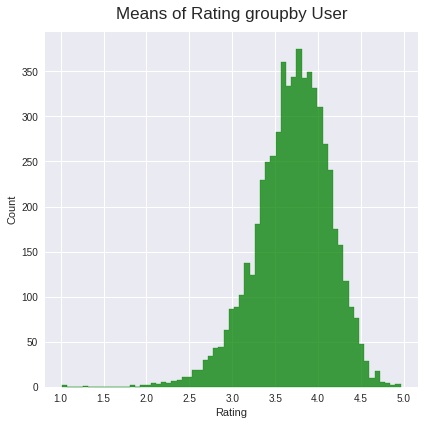

In [253]:
sns.histplot(mean_rating, element="step", color='green')
plt.title('Means of Rating groupby User', size=17, y=1.02)
plt.show()

In [254]:
# 평점이 낮은 하위 User Masking
# 기존보다 5만 개의 데이터가 줄어들어
# 95%정도의 데이터로 학습하고자 한다.
treshold = data.groupby('UserId')['Rating'].mean().quantile(p)
mask = mean_rating[mean_rating >= treshold].index
data = data[data['UserId'].isin(mask)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951468 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   UserId  951468 non-null  int32
 1   ItemId  951468 non-null  int32
 2   Rating  951468 non-null  int32
 3   Time    951468 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 25.4 MB


#### Adding Session column

In [255]:
# Time으로 묶어서 나누고 Session을 정의
# 2이상인 Session의 개수
# 적당한 data 개수라고 판단
(data.groupby(['UserId', 'Time']).size() >= 2).sum()

233925

In [256]:
# Time 컬럼만으로 indexing을 하면 전혀 상관없는 사람의 평가가 sequence로 연결될 수 있음을 확인
# UserId와 Time으로 묶었을 때와 Time컬럼만으로 묶었을 때 길이가 일치하지 않기 때문에 userid와 time을 고려해서 session id를 생성
len(data.groupby(['UserId', 'Time']).size()), len(set(data['Time']))

(452234, 440762)

In [257]:
yo = data.groupby(['UserId', 'Time']).size()
index_yo = yo.reset_index().index.to_numpy()
val_yo = yo.to_numpy()
index_yo

array([     0,      1,      2, ..., 452231, 452232, 452233])

In [258]:
session = []
for idx, cnt in zip(index_yo, val_yo):
    session.extend([idx] * cnt)

len(session)

951468

In [259]:
# 더 이상 Time, Rating은 필요없다고 판단
# 컬럼 순서를 바꾼다
data['Session'] = session
del data['Rating']
del data['UserId']

In [260]:
data = data[['Session', 'ItemId', 'Time']]
data.reset_index(drop=True, inplace=True)
data.tail()

,Session,ItemId,Time
951463,452230,2917,997454429
951464,452231,1921,997454464
951465,452231,1784,997454464
951466,452232,161,997454486
951467,452233,1221,998315055


#### Session Length Filter

size vs count

size
 - Series를 출력
 - NaN 값을 포함함 --> len처럼 작동

count
 - DataFrame 출력
 - NaN 값을 포함하지 않음

In [261]:
session_length = data.groupby('Session').size()
session_length

Session
0         1
1         3
2         1
3         1
4         1
         ..
452229    1
452230    1
452231    2
452232    1
452233    1
Length: 452234, dtype: int64

In [262]:
# 세션의 길이에 대한 통계
session_length.describe()

count    452234.000000
mean          2.103928
std           1.520105
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
dtype: float64

In [263]:
# 위에서 봤던 대로 2이상의 데이터면 충분하다고 생각한다.
yo = (session_length[session_length >= 2]).index


In [264]:
# Time이 평가를 내린 시점에 대한 정보라서
# 사실 추천에 아무 소용이 없는 정보 아닌가? 싶다(정확히는 목표에 도움이 안되는 Data)
# 왜냐하면 생각나는 대로 평가를 하기 때문에 평가 묶음이라고 해서 서로 연관이 있는 것은 아니기 때문이다.
# 크게 유의미한 분석과 결과를 도출하지 않을 것이라 판단하여
# 길이의 값은 2이상으로 정했다.
data = data[data['Session'].isin(yo)]

In [265]:
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733159 entries, 0 to 733158
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   Session  733159 non-null  int64
 1   ItemId   733159 non-null  int32
 2   Time     733159 non-null  int64
dtypes: int32(1), int64(2)
memory usage: 14.0 MB


#### Split train, val, test

Session Based Recommendation의 경우 Train - validation - Test의 데이터를 기간으로 나누기도 한다.

In [266]:
# README에 따르면 Time은 '초'로 해석하면 된다.
length_time = data['Time'].max() - data['Time'].min()
length_time

89750594

In [267]:
# 대략 3년정도의 기간이며
# 3년이면 영화추천에 크게 변화를 주지 않을 것이라 판단하였고(사실 데이터가 적어서)
# 다음과 같이 나누겠다
# 1~30 train
# 31~32 val
# 33~ test
length_time / (3600*24*30)

34.626000771604936

In [268]:
# Time 컬럼이 dtype = int임을 상기하면
threshold_train = data['Time'].min() + (3600*24*30)*30
threshold_val = threshold_train + (3600*24*30)*2
threshold_train, threshold_val

(1034463954, 1039647954)

In [269]:
train = data[data["Time"] <= threshold_train]
val = data[(data["Time"] > threshold_train) & (data["Time"] <= threshold_val)]
test = data[data["Time"] > threshold_val]
len(train), len(val), len(test)

(729969, 1480, 1710)

### Pipeline

In [270]:
c = train.columns
c = ['SessionId'] + list(c[1:])
c

['SessionId', 'ItemId', 'Time']

In [293]:
train.columns = c
val.columns = c
test.columns = c

In [272]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [273]:
tr_dataset = SessionDataset(train)
tr_dataset.df.head(10)

,SessionId,ItemId,Time
0,1,1270,978300055
1,1,1721,978300055
2,1,1022,978300055
3,5,2804,978300719
4,5,1207,978300719
5,6,1193,978300760
6,6,720,978300760
7,6,260,978300760
8,14,1035,978301753
9,14,1962,978301753


In [274]:
tr_dataset.click_offsets

array([     0,      3,      5, ..., 729965, 729967, 729969], dtype=int32)

In [275]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 232698, 232699, 232700])

In [276]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['ItemId'].values[start + i]
                target = self.dataset.df['ItemId'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [277]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,ItemId,Time
0,1,1270,978300055
1,1,1721,978300055
2,1,1022,978300055
3,5,2804,978300719
4,5,1207,978300719
5,6,1193,978300760
6,6,720,978300760
7,6,260,978300760
8,14,1035,978301753
9,14,1962,978301753


In [278]:
iter_ex = iter(tr_data_loader)

In [279]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [1270 2804 1193 1035]
Label Item Idx are :       [1721 1207  720 1962]
Previous Masked Input Idx are []


In [280]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [281]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [295]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, val, test, batch_size=1024, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [296]:
model = create_model(args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(1024, 1, 3600)]         0         
_________________________________________________________________
GRU (GRU)                    [(1024, 50), (1024, 50)]  547800    
_________________________________________________________________
dropout_4 (Dropout)          (1024, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (1024, 3600)              183600    
Total params: 731,400
Trainable params: 731,400
Non-trainable params: 0
_________________________________________________________________


In [284]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [285]:
# 복붙의 최후
train_model(model, args)

Train:   0%|          | 0/485 [00:00<?, ?it/s]


IndexError: index 3728 is out of bounds for axis 1 with size 3600

In [286]:
train.head()

,SessionId,ItemId,Time
0,1,1270,978300055
1,1,1721,978300055
2,1,1022,978300055
3,5,2804,978300719
4,5,1207,978300719


In [287]:
train['ItemId'].nunique()

3600

In [288]:
# 도대체 3728은 어디서 나오는 것일까
# 일단 ItemId를 re-Indexting하기로 했다.
train['ItemId'].max()

3952

In [289]:
d = {}
cnt = 0
for i in train["ItemId"]:
    if i not in d:
        d[i] = cnt
        cnt += 1

len(d)

3600

In [290]:
# 임시로 컬럼 이름을 yo로 설정
tmp = train['ItemId'].apply(lambda x: d[x])
tmp

0            0
1            1
2            2
3            3
4            4
          ... 
733154    1191
733155     148
733156     933
733157     305
733158      57
Name: ItemId, Length: 729969, dtype: int64

In [291]:
# 잘 처리된 것을 확인
train['ItemId'] = tmp
train.head()

,SessionId,ItemId,Time
0,1,0,978300055
1,1,1,978300055
2,1,2,978300055
3,5,3,978300719
4,5,4,978300719


In [294]:
val['ItemId'] = val['ItemId'].apply(lambda x: d[x])
test['ItemId'] = test['ItemId'].apply(lambda x: d[x])

In [297]:
train_model(model, args)

Train: 100%|█████████▉| 484/485 [00:35<00:00, 13.66it/s, accuracy=0.00391, train_loss=7.3]  
Evaluation: 0it [00:00, ?it/s]


IndexError: index 584 is out of bounds for axis 0 with size 584